In [4]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 20.0
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import loadMWSnap as mws
import velocitySpectroscopyHelpers as vsh
reload(mws);
reload(vsh);

In [11]:
# pos in physical kpc, vel in km/s, mass in physical m_sun
pos, vel, partmass, ldim, data = mws.loadMWSnap(halo=374, verbose=False)
pos -= vsh.pos_sun
vel -= vsh.vel_sun

In [2]:
# !make -B -C cfuncs
# reload(vsh);
# vsh.spectroscopy_c()

In [18]:
reload(vsh);  
hpspec = vsh.spectroscopy_healpix(pos, vel, partmass, nside=16)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


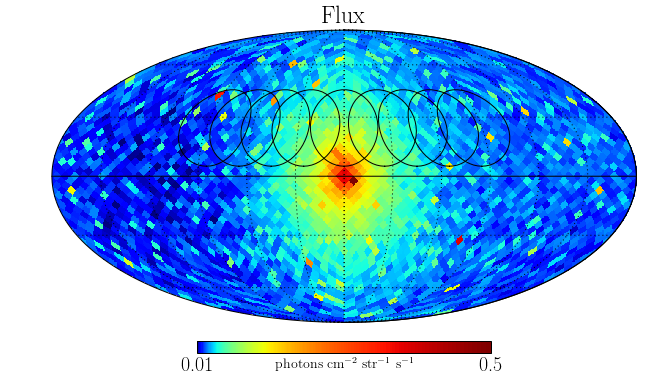

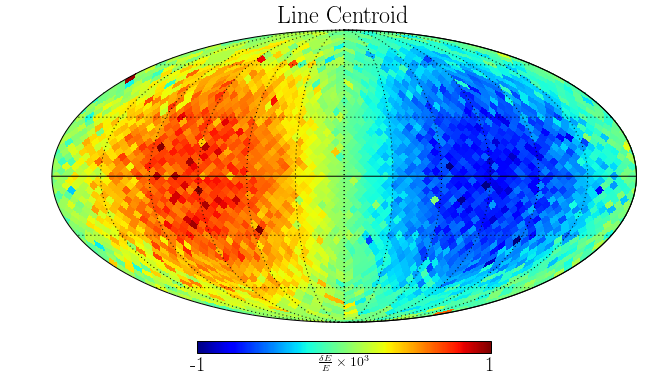

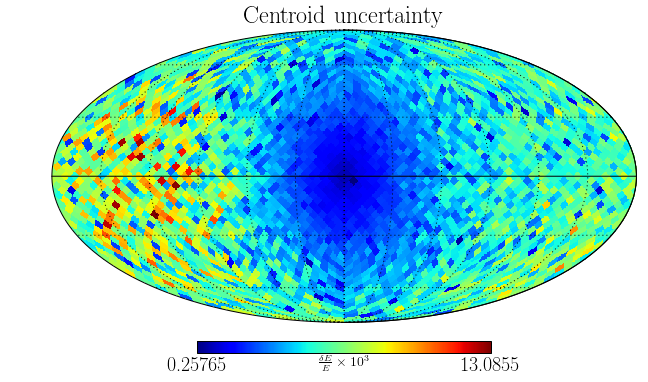

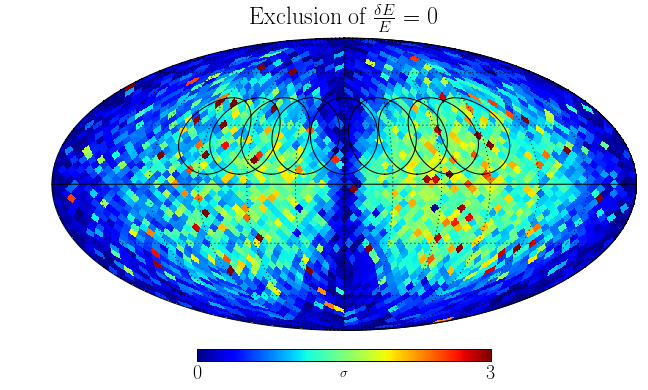

In [23]:
def plot_beams(lon=[-85., -65., -45., -25., 0.0, 25., 45., 65., 85.], lat=25.0, beamrad=20.0):
    beamargs = {'rot': (180,0,0), 'lonlat': True, 'c': 'black'} 
    bphi = np.linspace(0., 360., 50)
    bthe = (90.0-beamrad)*np.ones_like(bphi)
    for l in lon:
        beamargs['rot'] = (180.0-l, lat, 0.0)
#         hp.projscatter(0, 90.0, **beamargs)
        hp.projplot(bphi, bthe, **beamargs)

# make Moll
mapargs = {'rot': (180,0,0)} 

# properly scale flux for astro-h to get number counts
ahs = 1.0*0.37892243899248773*300.0

hp.mollview(hpspec['flux'], norm='log', title='Flux', min = .01, max=0.5, \
            unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', **mapargs)
plot_beams()
hp.graticule();

hp.mollview(hpspec['centroid']*10**3, min=-1.0, max=1.0, title='Line Centroid', \
            unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs)
hp.graticule();

hp.mollview(hpspec['sigma_centroid']*10**3, title='Centroid uncertainty', \
            unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs)
hp.graticule();

hp.mollview(np.abs(hpspec['centroid']/hpspec['sigma_centroid'])*ahs**0.5, min = 0, max=3, \
            title=r'Exclusion of $\frac{\delta E}{E}=0$', unit=r'$\sigma$', **mapargs)
plot_beams()
hp.graticule();


In [ ]:
'''
# hp.mollview(centroid*10**3, norm=None, title='Line centroid', \
#             unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs)
# hp.graticule();

# hp.mollview(mass, norm='log', title='Mass', **mapargs)
# hp.graticule();

# hp.mollview(em_radius, norm=None, title='Mean emission radius', \
#             unit=r'kpc', **mapargs)
# hp.graticule();
'''

In [ ]:
# an example plot to show how sampling is done
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
zoom = 800 # kpc
ax.set_xlim([-0.5*zoom, 0.5*zoom])
ax.set_ylim([-0.5*zoom, 0.5*zoom])
ax.set_title(r'MW halo: Sampling a thin cone along the LOS')
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
cpos, _, _ = sample_los(pos-pos_sun, vel-vel_sun, beam=3.0)
sfilt = np.abs(pos[:,2]) < 1.0 # filter all particles into a thin 1 kpc slab to make plotting easier
ax.scatter(pos[sfilt][:,0], pos[sfilt][:,1], s=0.5, c='black', lw=0)
ax.scatter(cpos[:,0], cpos[:,1], s=2.0, c='red', lw=0)

In [ ]:
# compare doppler shifting as a function of galactic longitude
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for lon in [-45., 0., 45.]:
    # sample along the los cone and calculate the los velocity
    # histogram, weighted by 1/r^2 to get spectrum
    _, v_los, r_los = sample_los(pos-pos_sun, vel-vel_sun, lon=lon, beam=5.0)
    hist, bins = np.histogram(v_los, bins=25, range=(-500, 500), weights=r_los**-2, density=True)
    bins = 0.5*(bins[1:]+bins[:-1])/c*10**3 # rescale bins to be in terms of fractional energy shift
    ax.plot(bins, hist, drawstyle='steps-mid', label=r'$%.1f^{\circ}$'%lon)
ax.set_title(r'Observed spectrum')
ax.set_xlabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_ylabel(r'Normalized $\frac{dN}{dE}$')
ax.legend()

In [ ]:
# compare doppler shifting as a function of galactic longitude
# including instrumental response and counting uncertainty

### Astro-H parameters ###
sigma_AH = 1.7/(3.5*10**3) # fractional energy resolution at 3.5 keV
A_eff = 200.0 # effective aperture in cm^2
Omega_fov = 9.0 # field of view in arcmin^2
t_exp = 2.0e6 # exposure time in sec

### Sampling / simulation parameters ###
beam_sample = 5.0 # full width of the sampling cone in degrees
Omega_sample = 2.0*np.pi*(1.0-np.cos(0.5*beam_sample*np.pi/180.0)) # sampling solid angle in str

### Sterile neutrino parameters from Bulbul+2014 ###
m_x = 7.1 # mass in keV
Gamma = (1.38e-29)*(7e-4)*(7.1)**5 # decay rate in s^-1

# mash all model parameters into a prefactor with correct unit conversions, 
# so that 1/r^2 weighting (r in kpc) is all that is required
# to get the photon number count into the detector
prefac = Gamma*t_exp*(partmass*1.12e63/m_x)*(Omega_fov/(Omega_sample*((10800./np.pi)**2)))\
    *(A_eff/(4.*np.pi*9.523396e42))
# print prefac

# sample and plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for lon in [-45., -30., -15., 0., 15., 30., 45.]:
    
    # sample along the los cone and calculate the los velocity
    # get the fractional energy shift from the speed of light
    _, v_los, r_los = sample_los(pos-pos_sun, vel-vel_sun, lon=lon, beam=beam_sample)
    de = v_los/c
    
    # mean energy and width of the dispersed line emission
    center = np.average(de, weights=r_los**-2)
    sigma_line = np.average((de-center)**2, weights=r_los**-2)**0.5
    
    # effective line width when convolved with Astro-H's energy resolution
    sigma_eff = (sigma_line**2 + sigma_AH**2)**0.5
    
    # get the photon number count for the given exposure
    Ns = prefac*np.sum(r_los**-2)
    
    # the error in the centroid according to Poisson stats
    sigma_center = sigma_eff * Ns**-0.5
    
    ax.errorbar(lon, center*10**3, yerr=sigma_center*10**3, fmt='o', c='black')
    
    # TODO: Include the counting uncertainty in the sim. particle number?
    # TODO: What about 1/r^2 in the sampling?
    # TODO: include background model from the Cramer-Rao theorem
    
ax.set_title(r'Decay line spectral shift')
ax.set_ylabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_xlabel(r'Galactic longitude ($^{\circ}$)')
# ax.legend()